## temel bilesen regresyonu - pcr - model tuning


In [1]:
import pandas as pd

# hitters.csv = basketbol oyuncularinin verilerini bulunduran veri seti

hit = pd.read_csv("Hitters.csv")
df = hit.copy()

df = df.dropna()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [2]:
y = df["Salary"]
x_ = df.drop(
    ["Salary", "League", "Division", "NewLeague"],
    axis=1,
).astype("float")

In [3]:
dms = pd.get_dummies(df[["League", "Division", "NewLeague"]])
dms.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,False,True,False,True,False,True
2,True,False,False,True,True,False
3,False,True,True,False,False,True
4,False,True,True,False,False,True
5,True,False,False,True,True,False


In [4]:
x = pd.concat([x_, dms[["League_N", "Division_W", "NewLeague_N"]]], axis=1)
x.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,True,True,True
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,False,True,False
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,True,False,True
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,True,False,True
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,False,True,False


In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42
)

training = df.copy()

In [6]:
from sklearn.decomposition import PCA

pca = PCA()

In [7]:
from sklearn.preprocessing import scale

x_reduced_train = pca.fit_transform(scale(x_train))

In [8]:
pca2 = PCA()
x_reduced_test = pca2.fit_transform(scale(x_test))

#### ========================================================

#### **Model Tuning kısmı burada başladı**


In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
pcr_model = lm.fit(x_reduced_train, y_train)
y_pred = pcr_model.predict(x_reduced_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

405.1575364149963


In [10]:
pcr_model = lm.fit(x_reduced_train[:, 0:1], y_train)
y_pred = pcr_model.predict(x_reduced_test[:, 0:1])
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# sadece ilk bileseni aldik
# bir bilesende elde ettigimiz hata 392

392.3893558949346


In [11]:
pcr_model = lm.fit(x_reduced_train[:, 0:2], y_train)
y_pred = pcr_model.predict(x_reduced_test[:, 0:2])
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# iki bilesenli yaptigimizda 396 oldu

396.38761247967653


model tuningi, hiperparametreleri optimize etme islemini icguduyle degil de cross validation yontemiyle, olasi bilesen sayisi degerlerini
bir vektor olarak gonderip, bunlarin denenip en guzel sonucun gelmesi sonrasinda optimum bilesen sayimizi belirleme islemi yapmis olacagiz.


In [12]:
from sklearn import model_selection

cv_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

# 10 katli cross validation yapilandirmasi yapmis olduk
# shuffle = verilerin gruplara ayrilmadan once karistirilip karistirilmayacaginı belirler

In [13]:
lm = LinearRegression()

In [14]:
RMSE = []

her bir bilesen icin olusturulacak modeller ile cross validation'a gore train hatasi hesaplanacak ve kaydetme islemi gerceklesecek

cikan sonuclari brute force yontemiyle gorsellestirip, degerlendirip, pcr icin en uygun bilesen sayisinin ne olduguna karar verilecek


In [15]:
for i in np.arange(1, x_reduced_train.shape[1] + 1):
    score = np.sqrt(-1*model_selection.cross_val_score(lm,
                                                       x_reduced_train[:, :i],
                                                       y_train.ravel(),
                                                       cv=cv_10,
                                                       scoring='neg_mean_squared_error').mean())
    RMSE.append(score)

# her bir bilesen icin model kuracak.

# her bir bilesen icin k-katli cross validation uygulayip hata degerlerini elde edip, hangi bilesen sayisinin daha az hata olusturdugu
# bilgisini verecek.

In [16]:
RMSE

[339.00500170955814,
 335.4728032081954,
 335.25905437554735,
 335.7884270015904,
 331.097406301735,
 329.0340331060009,
 328.1936807391625,
 331.4554758418423,
 333.6775747849661,
 339.503303868483,
 340.5292981595512,
 344.57665457588683,
 351.2608616797312,
 356.4667660069188,
 357.2309164188571,
 342.78343615942975,
 343.7456277253745,
 344.7519862573739,
 353.37050529908555]

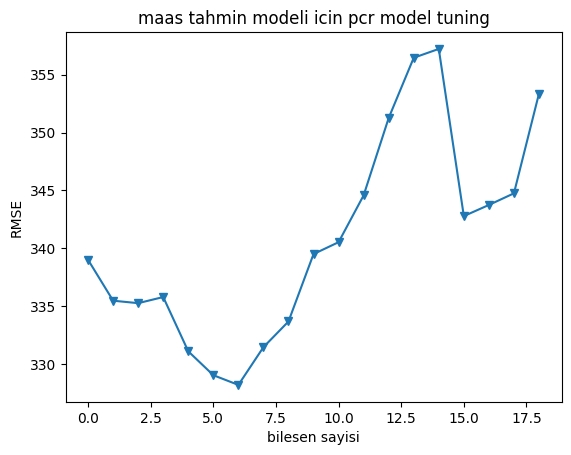

In [17]:
from matplotlib import pyplot as plt

plt.plot(RMSE, '-v')
plt.xlabel('bilesen sayisi')
plt.ylabel('RMSE')
plt.title('maas tahmin modeli icin pcr model tuning')

model hiperparametresini tahmin ettigimiz degeriyle, optimum bulmus oldugumuz degeri ile final modelini olusturmamiz gerekiyor


In [18]:
lm = LinearRegression()
pcr_model = lm.fit(x_reduced_train[:, 0:6], y_train)

In [19]:
y_pred = pcr_model.predict(x_reduced_train[:, 0:6])
print(np.sqrt(mean_squared_error(y_train, y_pred)))

# tahmin edilen degerler ile train icindeki gercek degerler icin egitim hatasi

308.8265983094501


In [20]:
y_pred = pcr_model.predict(x_reduced_test[:, 0:6])
print(np.sqrt(mean_squared_error(y_test, y_pred)))

# yukaridaki islemin aynisini test seti icin de gerceklestirelim

393.1198700096223


bir modele uygun hiperparametre degerini bulmak icin cross validation yontemini kullaniyoruz


en iyi parametre degerini bulmak icin train setini kullandiktan sonra train setimizle baska isimiz kalmiyor


daha sonra bulmus oldugumuz final parametre degeri ile final modelini kurmus oluyoruz


bu final modelini kurduktan sonra ise yeniden test ve train hatasini degerlendirmemiz gerekiyor


modeli kurarken daha once bulmus oldugumuz en uygun parametreyi modele gosteriyoruz ve train seti uzerinden modelimizi kuruyoruz


son asamada elimizde bulunan test setini degerlendirirken, cross validation yontemiyle degerlendirebiliriz veya direkt test hatasina gidebiliriz


- bundan sonraki bolumlerde model tuning islemi yaparak bu parametreleri bulacagiz, bu parametre degerleri ile final modellerini olusturacagiz, bu final modelleri uzerinden de son test hatalarini hesaplayacagiz

- bunu sinama seti yaklasimi ile hesaplar gibi hesaplayacagiz ki butun modellerle bu sekilde degerlendirme imkani bulmus olalim

- bu sekilde elde edilmis deger ise, tune edilmis modelimizin degeri olmus olacak

- optimum ulasmaya calistigimiz test hatamiz olmus olacak

- modeli tune etme islemini cross validation araciligiyla yapmis olaraktan parametremizi bulup son modeli kurdugumuzda, bu model uzerinden elde ettigimiz test seti hatasi bizim final test hatamiz olmus olacak.
